LACOUX Coline <br/>
EL MADAFRITE Saad 

# Projet ML 2020 : Inpainting

In [29]:
import numpy as np
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
import matplotlib.pyplot as plt
from sklearn import linear_model

# Partie 1 - Préambule : régression linéaire, régression ridge et TASSO

In [30]:
# TODO : trouver meilleur valeur de alpha pour ridge et lasso, chercher un indice de bonne classification pour comparer les algo

In [31]:
def load_usps(filename):
    with open(filename,"r") as f:
        f.readline()
        data =[ [float(x) for x in l.split()] for l in f if len(l.split())>2] 
        tmp = np.array(data)
    return tmp[: ,1:] ,tmp[: ,0]. astype(int)


In [32]:
datax_train , datay_train = load_usps ("data/USPS_train.txt")
datax_test , datay_test = load_usps ("data/USPS_test.txt")

datay_train = np.where(datay_train > 1 , 1 , -1)
datay_test = np.where(datay_test > 1 , 1 , -1)

In [33]:
linear_reg_model = linear_model.LinearRegression()
linear_reg_model.fit(datax_train, datay_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [34]:
ridge_model = linear_model.Ridge(alpha=10)
ridge_model.fit(datax_train, datay_train)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [35]:
lasso_model = linear_model.Lasso(alpha=0.1)
lasso_model.fit(datax_train, datay_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

number of non-zeros : 256


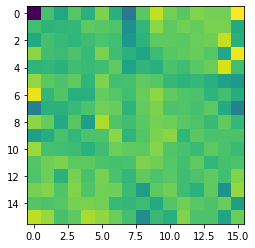

In [36]:
plt.imshow((linear_reg_model.coef_.reshape(16,16)), cmap=plt.cm.viridis )
print("number of non-zeros :", np.count_nonzero(linear_reg_model.coef_) )

number of non-zeros : 256


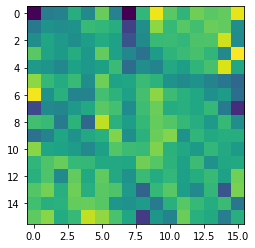

In [37]:
plt.imshow((ridge_model.coef_.reshape(16,16)), cmap=plt.cm.viridis )
print("number of non-zeros :", np.count_nonzero(ridge_model.coef_) )

number of non-zeros : 19


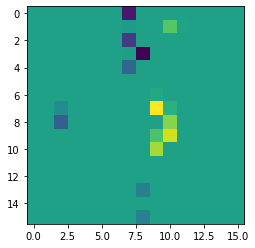

In [38]:
plt.imshow((lasso_model.coef_.reshape(16,16)), cmap=plt.cm.viridis )
print("number of non-zeros :", np.count_nonzero(lasso_model.coef_) )

In [39]:
pred_train = np.where(linear_reg_model.predict(datax_train) >= 0 , 1 , -1) 
pred_test = np.where(linear_reg_model.predict(datax_test) >= 0 , 1 , -1) 

print("Linear regression accuracy on train : ",(pred_train == datay_train).mean())
print("Linear regression accuracy on test  : ",(pred_test  == datay_test).mean())

Linear regression accuracy on train :  0.9668083939103004
Linear regression accuracy on test  :  0.9446935724962631


In [40]:
pred_train = np.where(ridge_model.predict(datax_train) >= 0 , 1 , -1) 
pred_test = np.where(ridge_model.predict(datax_test) >= 0 , 1 , -1) 

print("Ridge regression accuracy on train : ",(pred_train == datay_train).mean())
print("Ridge regression accuracy on test  : ",(pred_test  == datay_test).mean())

Ridge regression accuracy on train :  0.967219860101495
Ridge regression accuracy on test  :  0.9441953163926258


In [41]:
pred_train = np.where(lasso_model.predict(datax_train) >= 0 , 1 , -1) 
pred_test = np.where(lasso_model.predict(datax_test) >= 0 , 1 , -1) 

print("Lasso algorithm accuracy on train : ",(pred_train == datay_train).mean())
print("Lasso algorithm accuracy on test  : ",(pred_test  == datay_test).mean())

Lasso algorithm accuracy on train :  0.9041283774516528
Lasso algorithm accuracy on test  :  0.898355754857997


comparaison : conclusion, lasso selection de features car bcp de poids à 0 (seuls quelque pixels sont pris en comtpe)

# Partie 2 - TASSO et Inpainting

In [45]:
def read_img(filename):
    img = plt.imread(filename)
    img = rgb_to_hsv(img[:,:,0:3])
    img = -1 + 2*img
    return img

In [73]:
def show_img(img):
    img_to_show = np.where(img == -100, -1, img)
    img_to_show = (1 + img_to_show) / 2
    plt.imshow(hsv_to_rgb(img_to_show))


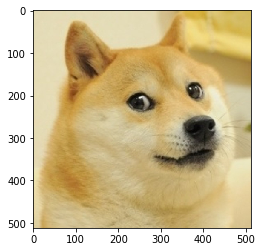

In [74]:
doge = read_img("data/doge.png")
show_img(doge)

In [75]:
def get_patch(i,j,h,img):
    return img[i-h//2:i+h//2:,j-h//2:j+h//2]

In [212]:
def patch_to_vect(patch):
    return patch.ravel()

In [213]:
def vect_to_patch(vect):
    h = int(np.sqrt(vect.size / 3))
    return vect.reshape(h,h,3)

(100, 100, 3)


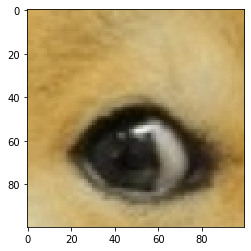

In [214]:
patch = get_patch(200,250, 100, doge)
show_img(patch)
print(patch.shape)

In [215]:
vect = patch_to_vect(patch)
print(vect.shape)

(30000,)


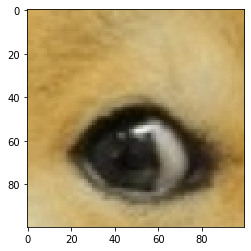

In [216]:
patch = vect_to_patch(vect)
show_img(patch)

In [217]:
def noise(img, prc):
    img_noised = img.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[0]):
            n = np.random.rand()
            if n < prc :
                img_noised[i,j] = [-100, -100, -100]
    return img_noised

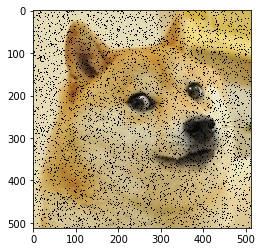

In [218]:
doge_noised = noise(doge, 0.1)
show_img(doge_noised)

In [219]:
def delete_rect(img,i,j,height,width):
    img_del = img.copy()
    img_del[i-height//2:i+height//2:,j-width//2:j+width//2] = -100
    return img_del

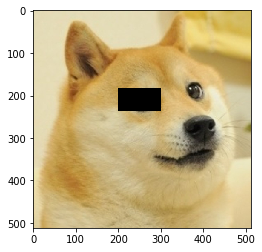

In [220]:
doge_pirate = delete_rect(doge, 210,250, 55,100)
show_img(doge_pirate)

In [221]:
def miss_pixel(patch):
    return np.argwhere(patch == -100).shape[0] > 0

In [255]:
def get_dictionary(img, step):
    dic = []
    height, width, dim = img.shape
    for i in range(step, height-step, step):
        for j in range(step, width-step, step):
            patch = get_patch(i, j, step, img)
            print(patch.shape)
            if not miss_pixel(patch):
                dic.append(patch)
    return dic

In [256]:
def get_patchs_missing_pixels(img, step):
    tab = []
    height, width, dim = img.shape
    for i in range(step, height-step, step):
        for j in range(step, width-step, step):
            patch = get_patch(i, j, step, img)
            if miss_pixel(patch):
                tab.append(patch)
    return tab

In [257]:
dic = get_dictionary(doge_pirate, 100)

(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)


In [258]:
print(len(dic))

14


In [259]:
missing_pixels = get_patchs_missing_pixels(doge_pirate, 100)
print(len(missing_pixels))

2


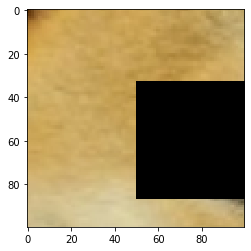

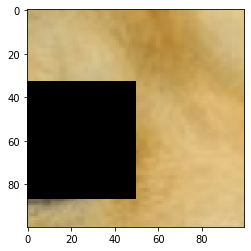

In [260]:
for patch in missing_pixels:
    show_img(patch)
    plt.show()

In [263]:
def learn_weigth(patch, dictionary):
    lasso_model = linear_model.Lasso(alpha=0.1)
    Y = patch_to_vect(patch)
    train_i = np.argwhere(Y != -100).ravel()
    test_i  = np.argwhere(Y == -100).ravel()
    X = np.empty((patch.size, len(dictionary)))
    for i in range(len(dictionary)):
        X[:,i] = patch_to_vect(dictionary[i])
    lasso_model.fit(X[train_i], Y[train_i])
    return lasso_model.coef_

In [264]:
coefs = learn_weigth(missing_pixels[0], dic)